# Forecasting Energy Demand 

## Exploratory Data Analysis (EDA)
The main question we want to answer is what is the relationship between the independent variables (weather features) and the dependent variable (electricity demand).

To get a feel for what is going on in the data and what we expect to be important/influential features in the model, we'll look at summary statistics and visualizations of the data before building a model

In [51]:
import boto3
import io
from sagemaker import get_execution_role

role = get_execution_role()
bucket ='sagemaker-data-energy-demand'

In [52]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm 
import seaborn as sns

In [53]:
CITY = 'LosAngeles'
df_file = 'dataframes/%s_dataset.csv' % CITY

df_location = 's3://{}/{}'.format(bucket, df_file)
df = pd.read_csv(df_location, index_col ='datetime', parse_dates=True)

(array([ 6245., 11584., 12340.,  4572.,  2224.,  1497.,   833.,   385.,
          103.,    25.]),
 array([2019. , 2526.6, 3034.2, 3541.8, 4049.4, 4557. , 5064.6, 5572.2,
        6079.8, 6587.4, 7095. ]),
 <a list of 10 Patch objects>)

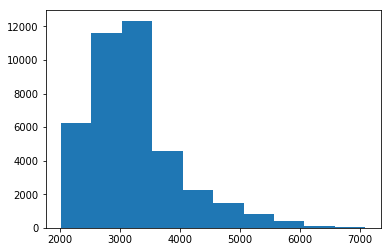

In [54]:
plt.hist(df.demand)

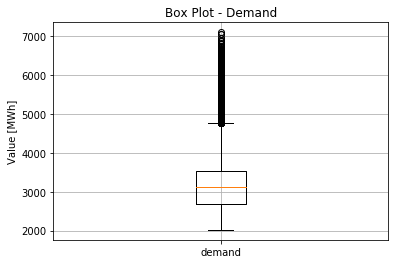

In [55]:
plt.boxplot([df['demand']], labels=['demand'])
plt.title('Box Plot - Demand')
plt.ylabel('Value [MWh]')
plt.grid(True)

In [56]:
# get pearson correlation coefficients for demand
print('DEMAND CORRELATIONS (PEARSON)')
print(df.corr()['demand'].sort_values(ascending=False)[1:])

# get r^2 values per column and print
demand_r = {}
for col in df.columns:
    if col != 'demand':
        if col != 'date':
            slope, intercept, r_value, p_value, std_err = scipy.stats.stats.linregress(df['demand'], df[col])
            demand_r[col] = float(r_value**2)

print(' ')
print('***')
print(' ')
print('DEMAND CORRELATIONS (r^2)')
demand_r_df = pd.DataFrame({'col': list(demand_r.keys()), 'r^2': list(demand_r.values())})
print(demand_r_df.sort_values(by='r^2', ascending=False))

DEMAND CORRELATIONS (PEARSON)
dailycoolingdegreedays       0.546146
hourlyrelativehumidity       0.362748
hourlydewpointtemperature    0.360728
hourlyskyconditions_CLR      0.030373
hourlyskyconditions_OVC      0.008051
hourlydrybulbtemperature     0.007550
hourlyvisibility            -0.005753
hourlyprecipitation         -0.019544
hourlyskyconditions_BKN     -0.030600
hourlyskyconditions_SCT     -0.035131
hourlyskyconditions_FEW     -0.036383
hourlycoolingdegrees        -0.051200
hourlyheatingdegrees        -0.077133
dailyheatingdegreedays      -0.208467
hourlywindspeed             -0.224430
hourlystationpressure       -0.225220
hourlysealevelpressure      -0.228396
Name: demand, dtype: float64
 
***
 
DEMAND CORRELATIONS (r^2)
                          col       r^2
0      dailycoolingdegreedays  0.298276
5      hourlyrelativehumidity  0.131586
2   hourlydewpointtemperature  0.130125
6      hourlysealevelpressure  0.052165
7       hourlystationpressure  0.050724
9             hourlyw

In [57]:
# here we store summary statistics of all the columns in a separate df for visualization
df_eda = df.copy()
stds = df_eda.std()
means = df_eda.mean()
medians = df_eda.median()

df_stats = pd.DataFrame({'std': stds, 'mean': means, 'median': medians})
print(df_stats.sort_values('std', ascending=False))

                                  std         mean   median
demand                     748.273200  3233.926598  3117.00
hourlyrelativehumidity      20.264733    62.557099    66.00
hourlydewpointtemperature   11.628788    50.951894    54.00
hourlydrybulbtemperature     9.362041    66.268162    66.00
hourlycoolingdegrees         6.291581     4.255577     0.00
dailycoolingdegreedays       5.502559     4.824030     3.00
hourlyheatingdegrees         4.723196     3.034164     0.00
dailyheatingdegreedays       3.532670     2.042002     0.00
hourlywindspeed              2.404804     1.576794     0.00
hourlyvisibility             1.801782     9.195790    10.00
hourlyskyconditions_CLR      0.449125     0.719755     1.00
hourlyskyconditions_OVC      0.389955     0.187048     0.00
hourlyskyconditions_BKN      0.199097     0.041348     0.00
hourlyskyconditions_FEW      0.164930     0.027984     0.00
hourlyskyconditions_SCT      0.146704     0.022006     0.00
hourlysealevelpressure       0.108851   

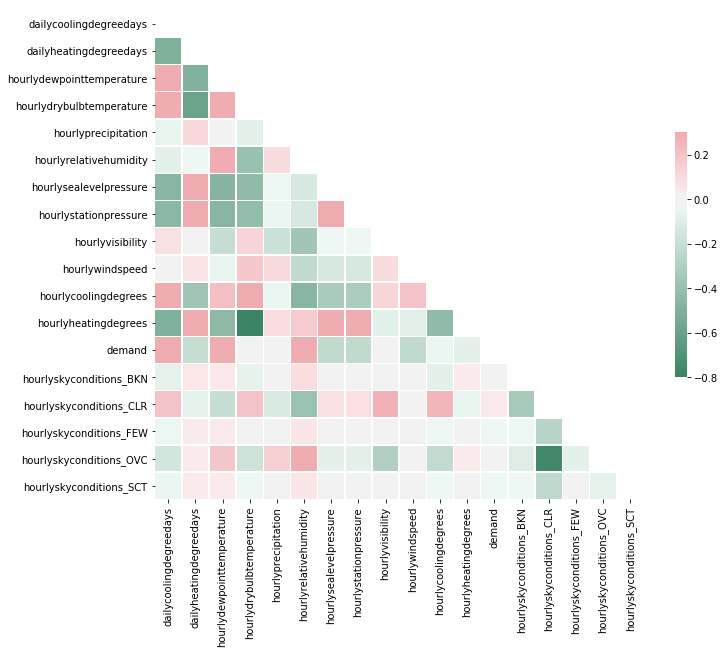

In [58]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(150, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Generating OLS Regression

In [59]:
def multiple_regression(df):
    X = df[[col for col in df.columns if col != 'demand']]
    y = df['demand']
    X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model
    
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    print(model.summary())
    return model

mreg = multiple_regression(df)

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     4660.
Date:                Fri, 17 Jan 2020   Prob (F-statistic):               0.00
Time:                        03:30:33   Log-Likelihood:            -2.9812e+05
No. Observations:               39808   AIC:                         5.963e+05
Df Residuals:                   39790   BIC:                         5.964e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


In [60]:
df = df.drop(['hourlysealevelpressure', 'hourlystationpressure', 'hourlyskyconditions_OVC', 'hourlyskyconditions_CLR'], axis=1)

In [61]:
# save as csv file to continue in another notebook
s3_resource = boto3.resource('s3')

df_buffer = io.StringIO()
df_key = 'dataframes/%s_dataset.csv' % CITY
df.to_csv(df_buffer, compression=None)

s3_resource.Object(bucket, df_key).put(Body=df_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'CE71A9BB2995A929',
  'HostId': 'VG0DGI/yHwrD60fUYn09/HgU4Qkg97JuUcX0YSZfdaTvY34G3YX2VLbaDjMUO7tRB8BA0SQ5zXk=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'VG0DGI/yHwrD60fUYn09/HgU4Qkg97JuUcX0YSZfdaTvY34G3YX2VLbaDjMUO7tRB8BA0SQ5zXk=',
   'x-amz-request-id': 'CE71A9BB2995A929',
   'date': 'Fri, 17 Jan 2020 03:31:12 GMT',
   'etag': '"601d0371daf9b1d7c7d9f9b1fb362add"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"601d0371daf9b1d7c7d9f9b1fb362add"'}